In [1]:
import numpy as np
import torch
import torchvision.transforms as transforms
import lightning as L
from torchvision.models import vit_b_16 # pretrained model
import torchmetrics
import cv2
import optuna

import brain_tumor_dataset as btd

c:\Users\Andreas\anaconda3\envs\deep_learning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Pre trained model

In [2]:
class BrainTumorDataModule(L.LightningDataModule):
	def __init__(self, batch_size):
		super().__init__()
		self.batch_size = batch_size

	def setup(self, stage=None):
		transform = transforms.Compose([
			transforms.Grayscale(num_output_channels=3),   # convert to 3 channels
			transforms.ToTensor(),
			btd.CropImgTransform(),                		   # crop the image
			transforms.Resize((224, 224)),                 # resize to 224x224
			
		])

		self.train_dataset = btd.BrainTumorDataset(btd.TRAIN_DATA_PATH, transform=transform)
		self.test_dataset = btd.BrainTumorDataset(btd.TEST_DATA_PATH, transform=transform)

		val_size = len(self.test_dataset) // 2
		test_size = len(self.test_dataset) - val_size
		self.test_dataset, self.val_dataset = torch.utils.data.random_split(self.test_dataset, [test_size, val_size])

	def train_dataloader(self):
		return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

	def val_dataloader(self):
		return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

	def test_dataloader(self):
		return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

In [7]:
def print_class_distribution(dataset, dataset_name):
    class_counts = {}
    for _, label in dataset:
        class_name = btd.BrainTumorDataset().idx_to_class[label]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1

    print(f"Class distribution in {dataset_name}:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")
    print("\n")

# Assuming you have already set up the data module
dm = BrainTumorDataModule(32)
dm.setup()



In [9]:
# Print distributions
# print_class_distribution(dm.train_dataset, "Training Set")
# Class distribution in Training Set:
# glioma: 1321
# meningioma: 1339
# notumor: 1595
# pituitary: 1457
print(f'glimo: {1321/sum([1321, 1339, 1595, 1457])}')
print(f'meningioma: {1339/sum([1321, 1339, 1595, 1457])}')
print(f'notumor: {1595/sum([1321, 1339, 1595, 1457])}')
print(f'pituitary: {1457/sum([1321, 1339, 1595, 1457])}')

glimo: 0.23126750700280113
meningioma: 0.2344187675070028
notumor: 0.27923669467787116
pituitary: 0.2550770308123249


In [8]:
print_class_distribution(dm.val_dataset, "Validation Set")
print_class_distribution(dm.test_dataset, "Test Set")

Class distribution in Validation Set:
glioma: 147
notumor: 210
pituitary: 143
meningioma: 155


Class distribution in Test Set:
notumor: 195
glioma: 153
pituitary: 157
meningioma: 151




In [10]:
# Class distribution in Validation Set:
# glioma: 147
# notumor: 210
# pituitary: 143
# meningioma: 155

print(f'glimo: {147/sum([147, 155, 210, 143])}')
print(f'meningioma: {155/sum([147, 155, 210, 143])}')
print(f'notumor: {210/sum([147, 155, 210, 143])}')
print(f'pituitary: {143/sum([147, 155, 210, 143])}')

# Class distribution in Test Set:
# notumor: 195
# glioma: 153
# pituitary: 157
# meningioma: 151

print(f'glimo: {153/sum([153, 151, 195, 157])}')
print(f'meningioma: {151/sum([153, 151, 195, 157])}')
print(f'notumor: {195/sum([153, 151, 195, 157])}')
print(f'pituitary: {157/sum([153, 151, 195, 157])}')


glimo: 0.22442748091603054
meningioma: 0.2366412213740458
notumor: 0.32061068702290074
pituitary: 0.2183206106870229
glimo: 0.23323170731707318
meningioma: 0.2301829268292683
notumor: 0.2972560975609756
pituitary: 0.23932926829268292


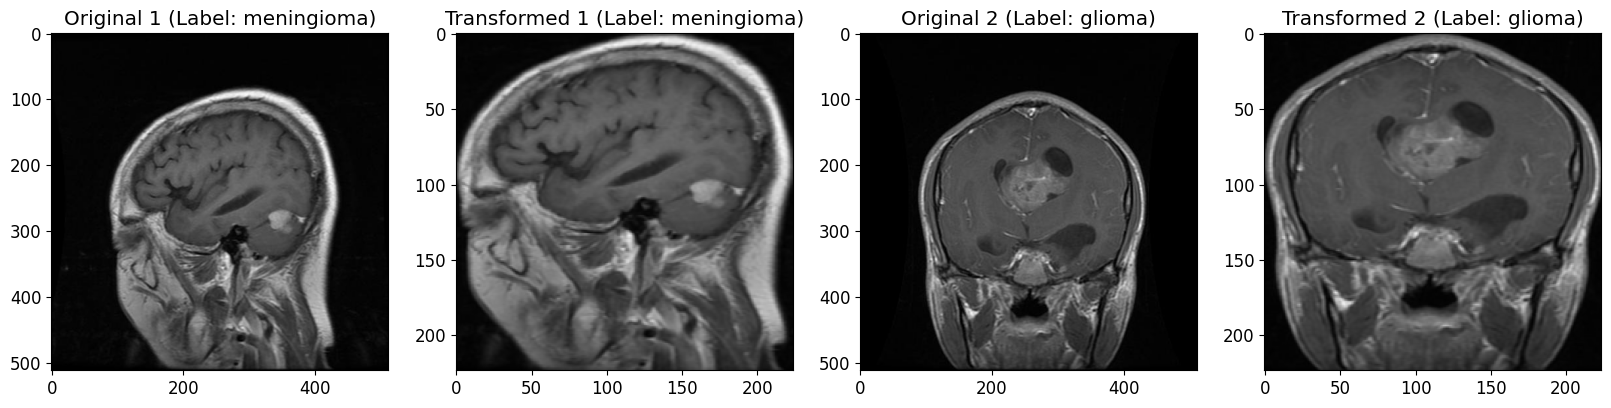

In [18]:
# test 
ds = btd.BrainTumorDataset(btd.TRAIN_DATA_PATH)

# get two samples
img1, label1 = ds[2000] #img1 is a jpeg image
img2, label2 = ds[1]

label1 = btd.BrainTumorDataset().idx_to_class[label1]
label2 = btd.BrainTumorDataset().idx_to_class[label2]

# transform the images	
transform = transforms.Compose([
	transforms.Grayscale(num_output_channels=3),   # convert to 3 channels
	transforms.ToTensor(),
	btd.CropImgTransform(),                		   # crop the image
	transforms.Resize((224, 224)),                 # resize to 224x224
])

img1_t = transform(img1)
img2_t = transform(img2)

# show the images before and after transformation using matplotlib in a 1x4 grid
import matplotlib.pyplot as plt
# set the figure size
plt.figure(figsize=(20, 10))

plt.subplot(1, 4, 1)
plt.imshow(img1)
plt.title(f'Original 1 (Label: {label1})')
plt.subplot(1, 4, 2)
plt.imshow(img1_t.permute(1, 2, 0))
plt.title(f'Transformed 1 (Label: {label1})')
plt.subplot(1, 4, 3)
plt.imshow(img2)
plt.title(f'Original 2 (Label: {label2})')
plt.subplot(1, 4, 4)
plt.imshow(img2_t.permute(1, 2, 0))
plt.title(f'Transformed 2 (Label: {label2})')
# set font size
plt.rcParams.update({'font.size': 14})





In [ ]:
# Define the PyTorch Lightning Module
class BrainTumorClassifier(L.LightningModule):
	def __init__(self, 
			  	learning_rate=1e-4, 
				weight_decay=0.01,
			  	pretrained_weights = "IMAGENET1K_V1"):
		super().__init__()

		self.save_hyperparameters()  # Save hyperparameters for easy access

		# Initialize the model with the pre-trained ViT
		self.model = vit_b_16(weights=pretrained_weights)
		self.model.heads = torch.nn.Linear(self.model.hidden_dim, 4)  # Modify for 4 classes

		# Define loss function
		self.criterion = torch.nn.CrossEntropyLoss()

		# Initialize accuracy metric for logging
		self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4)
		self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4)

		self.attention_maps = {}  # To store attention maps

	def forward(self, x):
		return self.model(x)

	def training_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
		self.train_accuracy(outputs, labels)
		self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True)

		return loss
	
	def validation_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('val_loss', loss, on_epoch=True, prog_bar=True)
		self.val_accuracy(outputs, labels)
		self.log('val_acc', self.val_accuracy, on_epoch=True, prog_bar=True)

		return loss

	def test_step(self, batch, batch_idx):
		inputs, labels = batch
		outputs = self(inputs)
		loss = self.criterion(outputs, labels)

		# Log loss and accuracy
		self.log('test_loss', loss, on_epoch=True, prog_bar=True)
		self.val_accuracy(outputs, labels)
		self.log('test_acc', self.val_accuracy, on_epoch=True, prog_bar=True)

		self.log_attention_maps(inputs, labels, outputs, batch_idx)  # Save attention maps

		return loss
	
	def configure_optimizers(self):
		return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate, weight_decay=self.hparams.weight_decay)
	
	def register_attention_hooks(self):
		"""Register hooks to capture attention maps."""
		self.attention_maps.clear()  # Reset attention maps

		def hook_fn(module, input, output, module_name):
			module_name = module_name.split(".")[2]  # Get the layer name
			# inside vision_transformer.py, change the forward function of EncoderBlock to 
			# x, _ = self.self_attention(x, x, x, need_weights=True) | and set need_weights=True not False
			self.attention_maps[module_name] = output[1]  # Save the attention map

		# Register hooks on all MultiheadAttention layers
		for i, module in self.model.named_modules():
			if isinstance(module, torch.nn.MultiheadAttention):
				module.register_forward_hook(lambda module, input, output, module_name=i: hook_fn(module, input, output, module_name))
	
	def on_test_start(self):
		# Register the hook to each multi-head attention layer before testing
		self.register_attention_hooks()

	def log_attention_maps(self, inputs, labels, output, batch_idx):
			"""Log attention maps overlaid on the original image using Lightning's logger."""
			
			predicted_labels = [btd.BrainTumorDataset().idx_to_class[lbl.item()] for lbl in torch.argmax(output, dim=1)]
			batch_size = inputs.size(0)
			for i in range(batch_size):
				rollout_attention_map = torch.eye(self.attention_maps['encoder_layer_1'].size(-1))
				for _, attention in self.attention_maps.items():
					# Get the attention map for the first image in the batch
					attention_map = attention[i]  # Shape: [num_tokens, embedding_size]
     
					attention_map = attention_map + torch.eye(attention_map.size(-1))  # Add identity matrix
					attention_map /= attention_map.sum(dim=-1, keepdim=True)  # Normalize attention map
					if rollout_attention_map is None:
						rollout_attention_map = attention_map
					else:
						rollout_attention_map = torch.matmul(rollout_attention_map, attention_map)

				# class_token_embedding = class_token_embedding / torch.norm(class_token_embedding)
				num_patches_side = int((attention_map.size(0) - 1) ** 0.5)
				class_token_embedding = rollout_attention_map[0, 1:] # Shape: (embedding_size)
				attention_map = 1 - class_token_embedding.view(num_patches_side, num_patches_side, -1).clone()
				attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())
				# average_attention_map = average_attention_map / num_layers

				average_attention_map = attention_map.cpu().detach().numpy()
				average_attention_map = cv2.resize(average_attention_map, (inputs.size(2), inputs.size(3)))
				heatmap = cv2.applyColorMap(np.uint8(255 * average_attention_map), cv2.COLORMAP_JET)

				# Overlay the heatmap on the original image
				image = inputs[i].cpu().numpy().transpose(1, 2, 0)
				image = (image*255).astype(np.uint8)
				overlayed_image = cv2.addWeighted(image, 0.8, heatmap, 0.4, 0)

				# add class label
				label = labels[i].item()
				label = btd.BrainTumorDataset().idx_to_class[label]
				cv2.putText(overlayed_image, f"Real class: {label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
				cv2.putText(overlayed_image, f"Predicted class: {predicted_labels[i]}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

				# convert to chw
				overlayed_image = overlayed_image.transpose(2, 0, 1)

				# log to tensorboard
				self.logger.experiment.add_image(f'attn_map/batch_{batch_idx}/img_{i}', overlayed_image, self.current_epoch)

# Optuna 
Using [this guide](https://medium.com/swlh/optuna-hyperparameter-optimization-in-pytorch-9ab5a5a39e77)

In [16]:
# optuna op

# Define the objective function for Optuna (the function to optimize)
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Create the model and data module with suggested hyperparameters
    model = BrainTumorClassifier(learning_rate=learning_rate, weight_decay=weight_decay)
    data_module = BrainTumorDataModule(batch_size=batch_size)

    # Define callbacks
    checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        dirpath="checkpoints/",
        filename="epoch-{epoch:02d}-val_loss-{val_loss:.2f}",
        save_top_k=1,
    )

    early_stopping_callback = L.pytorch.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        mode="min",
        verbose=True,
    )

    logger = L.pytorch.loggers.TensorBoardLogger("logs", name="vit_pretrained")

    # Define the PyTorch Lightning Trainer
    trainer = L.Trainer(
        max_epochs=10,
        accelerator="auto",
        logger=logger,
        callbacks=[checkpoint_callback, early_stopping_callback]
    )

    # Train the model
    trainer.fit(model, datamodule=data_module)

    # Evaluate the model
    val_loss = trainer.callback_metrics["val_loss"].item()

    # report intermediate objective value
    trial.report(val_loss, step=trainer.current_epoch)

    # Handle pruning based on the intermediate value
    if trial.should_prune():
        raise optuna.TrialPruned()

    return val_loss

In [ ]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction="minimize", study_name="vit_pretrained")
study.optimize(objective, n_trials=10, show_progress_bar=True)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

In [21]:
# Test the model
weights_path = "logs/vit_pretrained/version_0/checkpoints/epoch-epoch=04-val_loss-val_loss=0.01.ckpt"
model = BrainTumorClassifier()
data_module = BrainTumorDataModule(batch_size=32)
model = BrainTumorClassifier.load_from_checkpoint(weights_path, map_location=model.device)
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
	monitor="val_loss",
	mode="min",
	dirpath="checkpoints/",
	filename="epoch-{epoch:02d}-val_loss-{val_loss:.2f}",
	save_top_k=1,
)

early_stopping_callback = L.pytorch.callbacks.EarlyStopping(
	monitor="val_loss",
	patience=5,
	mode="min",
	verbose=True,
)

logger = L.pytorch.loggers.TensorBoardLogger("logs", name="vit_pretrained")
# Define the PyTorch Lightning Trainer
trainer = L.Trainer(
	max_epochs=10,
	accelerator="auto",
	logger=logger,
	callbacks=[checkpoint_callback, early_stopping_callback]
)

trainer.test(model, datamodule=data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Andreas\anaconda3\envs\deep_learning\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 21/21 [02:36<00:00,  0.13it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8521341681480408     │
│         test_loss         │    0.6713635325431824     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6713635325431824, 'test_acc': 0.8521341681480408}]